In [55]:
import pandas as pd 
import numpy as np
import math

tmp = pd.read_csv('Weed_Resistance_Data.csv', sep = ',', header=None)
params_in = list(tmp[:21][0])


params_in = np.array(params_in)

In [56]:
class General:
    def __init__(self,params_in):
        self.nsim = params_in[0]             #number of simulations
        self.nYears = params_in[1]               #number of years
        self.nCohorts = params_in[2]             #number of cohorts
        self.nLoci = params_in[3]                            #number of gene loci
        self.nGeno = math.pow(3,self.nLoci)             #number of genotypes
        self.fieldSize = params_in[4]           #field size
        self.selfingCoeff = params_in[5]         #selfing coefficient 
        self.seedDelay = params_in[6]          #seed delay
        self.femaleFrac = params_in[7]
        self.f_RO = params_in[18]          #latent time
        self.f_CR = params_in[19]     #critical response
        self.f_TR = params_in[20]
        self.currentYear = 1
        self.currentCohort = 1
        self.TillingFreq = np.loadtxt('Corteva/BMP_Matlab_Code/Tilling_Data.txt')

In [57]:
class Upper:
    pass
class Lower:
    pass

In [58]:
class Init:
    def __init__(self, params_in):
        self.Upper = Upper
        self.Lower = Lower
        self.Upper.seedDensity = params_in[8]      #initial upper bank density
        self.Lower.seedDensity = params_in[9]       #initial lower bank density
        self.Upper.ResAlleleFreq = params_in[10:17:2]   #initial upper resistant allele frequency
        self.Lower.ResAlleleFreq = params_in[11:18:2] 

In [59]:
class Germination:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.survivalFraction = self.survivalfrac()


    def survivalfrac(self):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,0]
                if row < 49:
                    row += 1

        return survivalFraction
        

In [60]:
ger = Germination(tmp)
ger.survivalfrac()

array([[0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05],
       [0.05, 0.05]])

In [61]:
class Cultivation:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.survivalFraction = self.survivalfrac()


    def survivalfrac(self):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,1]
                if row < 49:
                    row += 1

        return survivalFraction

In [62]:
class Hand:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.survivalFraction = self.survivalfrac()


    def survivalfrac(self):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,2]
                if row < 49:
                    row += 1

        return survivalFraction

In [63]:
class Mature:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.maxplants = self.max_crop(3)
        self.cropParam = self.max_crop(4)
        self.weedCompetition = self.max_crop(5)

    def max_crop(self,column):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,column]
                if row < 49:
                    row += 1

        return survivalFraction

In [64]:
class SeedProd:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.maxyield = self.max_crop(6)
        self.cropParam = self.max_crop(7)
        self.weedCompetition = self.max_crop(8)

    def max_crop(self,column):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,column]
                if row < 49:
                    row += 1

        return survivalFraction

In [65]:
class Mutation:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])

        self.muR2S_locus1 = self.mut(9)
        self.muS2R_locus1 = self.mut(10)
        self.muR2S_locus2 = self.mut(11)
        self.muS2R_locus2 = self.mut(12)
        self.muR2S_locus3 = self.mut(13)
        self.muS2R_locus3 = self.mut(14)
        self.muR2S_locus4 = self.mut(15)
        self.muS2R_locus4 = self.mut(16)

    def mut(self,column):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,column]
                if row < 49:
                    row += 1

        return survivalFraction

In [66]:
class Predation:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.survivalFraction = self.survivalfrac(17)


    def survivalfrac(self,column):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,column]
                if row < 49:
                    row += 1

        return survivalFraction

In [67]:
class Winter:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.uppersurvivalFraction = self.survivalfrac(18)
        self.lowersurvivalFraction = self.survivalfrac(19)


    def survivalfrac(self,column):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,column]
                if row < 49:
                    row += 1

        return survivalFraction

In [68]:
General_TillingFrequency = np.loadtxt('Corteva/BMP_Matlab_Code/Tilling_Data.txt')
Herbicide_data = np.loadtxt('Corteva/BMP_Matlab_Code/Herbicide_Data.txt')

In [69]:
class Herbicide1:
    def __init__(self, Herbicide_data):
        self.general = General(params_in)
        self.data = Herbicide_data
        self.targetLocus = 1
        self.efficacy_SS = np.zeros((25,2))

        self.efficacy_SS[0:25,0] = Herbicide_data[0:25,1]
        self.efficacy_SS[0:25,1] = Herbicide_data[25:50,1]

        self.efficacy_RS = np.zeros((25,2))

        self.efficacy_RS[0:25,0] = Herbicide_data[0:25,2]
        self.efficacy_RS[0:25,1] = Herbicide_data[25:50,2]

        self.efficacy_RR = np.zeros((25,2))

        self.efficacy_RR[0:25,0] = Herbicide_data[0:25,3]
        self.efficacy_RR[0:25,1] = Herbicide_data[25:50,3]

In [70]:
class Herbicide2:
    def __init__(self, Herbicide_data):
        self.general = General(params_in)
        self.data = Herbicide_data
        self.targetLocus = 2
        self.efficacy_SS = np.zeros((25,2))

        self.efficacy_SS[0:25,0] = Herbicide_data[50:75,1]
        self.efficacy_SS[0:25,1] = Herbicide_data[75:100,1]

        self.efficacy_RS = np.zeros((25,2))

        self.efficacy_RS[0:25,0] = Herbicide_data[50:75,2]
        self.efficacy_RS[0:25,1] = Herbicide_data[75:100,2]

        self.efficacy_RR = np.zeros((25,2))

        self.efficacy_RR[0:25,0] = Herbicide_data[50:75,3]
        self.efficacy_RR[0:25,1] = Herbicide_data[75:100,3]

In [71]:
class Herbicide3:
    def __init__(self, Herbicide_data):
        self.general = General(params_in)
        self.data = Herbicide_data
        self.targetLocus = 3
        self.efficacy_SS = np.zeros((25,2))

        self.efficacy_SS[0:25,0] = Herbicide_data[100:125,1]
        self.efficacy_SS[0:25,1] = Herbicide_data[125:150,1]

        self.efficacy_RS = np.zeros((25,2))

        self.efficacy_RS[0:25,0] = Herbicide_data[100:125,2]
        self.efficacy_RS[0:25,1] = Herbicide_data[125:150,2]

        self.efficacy_RR = np.zeros((25,2))

        self.efficacy_RR[0:25,0] = Herbicide_data[100:125,3]
        self.efficacy_RR[0:25,1] = Herbicide_data[125:150,3]

In [72]:
class Herbicide4:
    def __init__(self, Herbicide_data):
        self.general = General(params_in)
        self.data = Herbicide_data
        self.targetLocus = 4
        self.efficacy_SS = np.zeros((25,2))

        self.efficacy_SS[0:25,0] = Herbicide_data[150:175,1]
        self.efficacy_SS[0:25,1] = Herbicide_data[175:200,1]

        self.efficacy_RS = np.zeros((25,2))

        self.efficacy_RS[0:25,0] = Herbicide_data[150:175,2]
        self.efficacy_RS[0:25,1] = Herbicide_data[175:200,2]

        self.efficacy_RR = np.zeros((25,2))

        self.efficacy_RR[0:25,0] = Herbicide_data[150:175,3]
        self.efficacy_RR[0:25,1] = Herbicide_data[175:200,3]

In [73]:
class P:
    def __init__(self,params_in, Herbicide_data,tmp):
        self.General = General(params_in)
        self.Init = Init(params_in)
        self.Germination = Germination(tmp)
        self.Cultivation = Cultivation(tmp)
        self.Hand = Hand(tmp)
        self.Mature = Mature(tmp)
        self.SeedProd = SeedProd(tmp)
        self.Mutation = Mutation(tmp)
        self.Predation = Predation(tmp)
        self.Winter = Winter(tmp)
        self.Herbicide1 = Herbicide1(Herbicide_data)
        self.Herbicide2 = Herbicide2(Herbicide_data)
        self.Herbicide3 = Herbicide3(Herbicide_data)
        self.Herbicide4 = Herbicide4(Herbicide_data)


In [74]:
par = P(params_in,Herbicide_data,tmp)

In [75]:
par.General.TillingFreq

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [76]:
class PrepareParams(P):
    def __init__(self):
        self.General = General(params_in)
        self.Init = Init(params_in)
        self.Germination = Germination(tmp)
        self.Cultivation = Cultivation(tmp)
        self.Hand = Hand(tmp)
        self.Mature = Mature(tmp)
        self.SeedProd = SeedProd(tmp)
        self.Mutation = Mutation(tmp)
        self.Predation = Predation(tmp)
        self.Winter = Winter(tmp)
        self.Herbicide1 = Herbicide1(Herbicide_data)
        self.Herbicide2 = Herbicide2(Herbicide_data)
        self.Herbicide3 = Herbicide3(Herbicide_data)
        self.Herbicide4 = Herbicide4(Herbicide_data)
        self.nLoci = int(self.General.nLoci)
        self.nGeno = int(self.General.nGeno)
        self.key, self.key_text = self.generate_key()
        self.General.UpperSeedBank = self.matingEquilibrium(self.Init.Upper.ResAlleleFreq,self.key)*self.Init.Upper.seedDensity
        self.General.LowerSeedBank = self.matingEquilibrium(self.Init.Lower.ResAlleleFreq,self.key)*self.Init.Lower.seedDensity          
        
    def generate_key(self):
        key = np.zeros((self.nLoci,self.nGeno))
        tmp = np.zeros((self.nLoci,1))
        for k in range(int(self.nGeno)):
            key[:,k] = tmp.reshape((4,))
            tmp = self.odometer(tmp,2)
        key_text = 0
        key_text = []
        for k in range(int(self.nGeno)):
            tmp = ''
            for j in range(int(self.nLoci)):
                locus_string = str(j+1)
                if key[j,k] == 0:
                    tmp = tmp + 'S' + locus_string + 'S' + locus_string
                elif key[j,k] == 1:
                    tmp = tmp + 'R' + locus_string + 'S' + locus_string
                else:
                    tmp = tmp + 'R' + locus_string + 'R' + locus_string
            key_text.append(tmp)
        # print('key text', key_text)
        return key, key_text
    
    def odometer(self,odo,base_num):
        Ndigits = len(odo)
        j = 0
        while j < Ndigits:
            if odo[j] < base_num:
                odo[j] = odo[j] +1
                break
            odo[j] = 0
            j = j+1
        return odo

    def matingEquilibrium(self,p1,key):
        q = 1 - p1
        populationFraction_outCross = np.ones((1,int(self.nGeno)))

        for j in range(int(self.nLoci)):
            for k in range((self.nGeno)):
                if key[j,k] == 2:
                    populationFraction_outCross[0][k] = populationFraction_outCross[0][k] *(math.pow(p1[j],2))
                elif key[j,k] == 1:
                    populationFraction_outCross[0][k] = populationFraction_outCross[0][k] *2*p1[j]*q[j]
                else:
                    populationFraction_outCross[0][k] = populationFraction_outCross[0][k] *(math.pow(q[j],2))

        return populationFraction_outCross[0]

In [77]:
Params = PrepareParams()

In [78]:
class Population:
    pass

In [79]:
nCohorts = int(Params.General.nCohorts)      
nYears = int(Params.General.nYears)        
nLoci = int(Params.General.nLoci)               
nGeno = int(Params.General.nGeno)              
fieldSize = int(Params.General.fieldSize)     


Population.seedBank = np.zeros((nYears,nGeno,nCohorts))


Population.lowerBank = np.zeros((nYears,nGeno))


Population.immSeed = np.zeros((nYears,nGeno,nCohorts))


Population.emSeed = np.zeros((nYears,nGeno,nCohorts))

Population.germination = np.zeros((nYears,nGeno,nCohorts))


Population.ungerminated = np.zeros((nYears,nGeno,nCohorts))


Population.herbicide1 = np.zeros((nYears,nGeno,nCohorts))
Population.herbicide2 = np.zeros((nYears,nGeno,nCohorts))
Population.herbicide3 = np.zeros((nYears,nGeno,nCohorts))
Population.herbicide4 = np.zeros((nYears,nGeno,nCohorts))
Population.seedProd = np.zeros((nYears,nGeno,nCohorts))

Population.mature = np.zeros((nYears,nGeno,nCohorts))


Population.hand = np.zeros((nYears,nGeno,nCohorts))


Population.immPol = np.zeros((nYears,nGeno,nCohorts))


Population.emPol = np.zeros((nYears,nGeno,nCohorts))


Population.newSeed = np.zeros((nYears,nGeno,nCohorts))


Population.mutated = np.zeros((nYears,nGeno,nCohorts))


Population.predation = np.zeros((nYears,nGeno,nCohorts))


Population.winter = np.zeros((nYears,nGeno))


Population.Res = np.zeros((1, 3))


Population.seedBank[0,:,0] = Params.General.UpperSeedBank
Population.lowerBank[0,:] = Params.General.LowerSeedBank

In [80]:
def deepTill(upperbank,lowerbank,tillFrequency,currentYear):
    if tillFrequency[currentYear] ==1:
        tmp = upperbank
        upperbank = lowerbank
        lowerbank = tmp 
    else:
        pass
    return upperbank, lowerbank

def seedImmigration(nGeno):
    seedIN = np.zeros(int(nGeno))
    return seedIN

def extinction(oldPopulation,fieldSize):
    # print("shape of oldpop from extinction: ", oldPopulation.shape)


    if fieldSize == math.inf:
        newPopulation = oldPopulation
    elif fieldSize == 0:
        newPopulation = oldPopulation
    else:
        nGeno = int(len(oldPopulation))
        rndExtinct = np.random.rand(nGeno)
        newPopulation = np.zeros(nGeno)

        for i in range(nGeno):
            if oldPopulation[i] == 0:
                newPopulation[i] =0
            elif oldPopulation[i] >= 1/fieldSize:
                newPopulation[i] = oldPopulation[i]
            elif rndExtinct[i] > 0.5:
                newPopulation[i] = 1/fieldSize
            else:
                newPopulation[i] = 0

    return newPopulation

def survival(oldPopulation,fSurvival):

    newPopulation = fSurvival*oldPopulation


    return newPopulation

def selectiveSurvival(oldPop,fSurvival,targetLocus,key):
    nLoci, nGeno = key.shape
    newPop = oldPop*0
    if targetLocus > nLoci:
        newPop = oldPop
    else:
        for i in range(int(nGeno)):
            if key[targetLocus-1][i] == 0:
                newPop[i] = fSurvival[0]*oldPop[i]
            elif key[targetLocus-1][i] == 1:
                newPop[i] = fSurvival[1]*oldPop[i]
            else: 
                newPop[i] = fSurvival[2]*oldPop[i]
    return newPop

def competition(oldPop,A,B,C):
    # print("type of oldpop: ", type(oldPop))

    if isinstance(oldPop, np.ndarray):
        # print("its a list")
        totalPop = float(np.sum(oldPop))
        
        a = [A*i for i in list(oldPop)]
        b = (1+B+C*totalPop)


        newPop = [i/b for i in a] 


    elif isinstance(oldPop,float):
        
        totalPop = oldPop
        a = A*oldPop
        b = (1+B+C*totalPop)
        

        newPop = a/b

    else:
        print("confusionnnn") 

    # print(" newpop: ", newPop)

    return newPop


def mating(population,s,key):

    nLoci,nGeno = key.shape
    if sum(population) == 0:
        newFracOut = np.zeros(len(population))
    else:
        newFracOut = np.ones(nGeno)
        p = np.zeros(nLoci)

        for j in range(int(nLoci)):
            for k in range(int(nGeno)):
                if key[j][k] == 2:
                    p[j] = p[j] + 2*population[k]
                elif key[j,k] == 1:
                    p[j] = p[j] + population[k]

        p = .5*p/sum(population)
        q = 1 -p

        for j in range(int(nLoci)):
            for k in range(int(nGeno)):
                if key[j][k] == 2:
                    newFracOut[k] = newFracOut[k]*(math.pow(p[j],2))
                elif key[j,k] == 1:
                    newFracOut[k] = newFracOut[k]*2*p[j]*q[j]
                else:
                    newFracOut[k] = newFracOut[k]*(math.pow(q[j],2))


    name = 'selfTable'+str(nLoci)+'.txt'
    name = './Corteva/BMP_Matlab_Code/' + name
    selfingTable = np.array(pd.read_csv(name, sep=',', header=None))
    newFracself = np.matmul(population,selfingTable)
    s = Params.General.selfingCoeff
    newFrac = s*newFracself + (1-s)*newFracOut

    return newFrac

def mutation(population,muS2R,muR2S,targetLocus,key):
    mu = muR2S
    nu = muS2R

    mutatedPopulation = population[0]

    for j in range(key.shape[1]):
        tmp = (j%math.pow(3,(targetLocus-1)))+1
        indSS = int(tmp-1)
        indRS = int(indSS + math.pow(3,(targetLocus-1)))
        indRR = int(indRS + math.pow(3,(targetLocus-1)))

        if key[targetLocus-1,j] == 2:
            mutatedPopulation[indRR] = mutatedPopulation[indRR] - 2*mu*population[indRR] + (mu**2)*population[indRR]
            mutatedPopulation[indRS] = mutatedPopulation[indRS] + 2*mu*population[indRR] - 2*(mu**2)*population[indRR]
            mutatedPopulation[indSS] = mutatedPopulation[indSS] + (mu**2)*population[indRR]
        elif key[targetLocus-1,j] == 1:
            mutatedPopulation[indRR] = mutatedPopulation[indRR] + nu*population[indRS] 
            mutatedPopulation[indRS] = mutatedPopulation[indRS] + nu*population[indRS] - mu*population[indRS]
            mutatedPopulation[indSS] = mutatedPopulation[indSS] + mu*population[indRS]    

        else:
            mutatedPopulation[indRR] = mutatedPopulation[indRR] + math.pow(nu,2)*population[indSS] 
            mutatedPopulation[indRS] = mutatedPopulation[indRS] + 2*nu*population[indSS] - 2*(math.pow(nu,2))*population[indSS]
            mutatedPopulation[indSS] = mutatedPopulation[indSS] - 2*nu*population[indSS] + (math.pow(nu,2))*population[indSS]
        population = mutatedPopulation

    return mutatedPopulation

In [81]:
nYears = int(Params.General.nYears)
nCohorts = int(Params.General.nCohorts)

# nYears = 1
# nCohorts = 2

for y in range(nYears):
    tempSeedBank = np.zeros(81)

    upperbank = Population.seedBank[y,:,1]
    lowerbank = Population.lowerBank[y,:]
    if Params.General.TillingFreq[y] == 1:
        tmpo = Population.seedBank[y,:,1]
        upperbank = Population.lowerBank[y,:]
        lowerbank = tmpo 
    else:
        pass

    Population.seedBank[y,:,1]= upperbank
    Population.lowerBank[y,:] = lowerbank

    # Population.seedBank[y,:,1],Population.lowerBank[y,:] = deepTill(Population.seedBank[y,:,1],
    #                                                             Population.lowerBank[y,:],
    #                                                             Params.General.TillingFreq,y)
    
    
    for c in range(nCohorts):
        
        ImmSeed = seedImmigration(nGeno)
        # print(ImmSeed)
        seedBank = Population.seedBank[y,:,c]+ ImmSeed
        

        seedBank = extinction(seedBank,fieldSize)


        fGerm = Params.Germination.survivalFraction[y,c]

        germination = survival(seedBank,fGerm)




        ungerminated = seedBank - germination





        germination = extinction(germination,fieldSize)


        print("year: ",y," cohort: ", c, " variable: ", germination)   


        fCult = Params.Cultivation.survivalFraction[y,c]


  
        cult = survival(germination,fCult)
        cult = extinction(cult,fieldSize)





        fSS = 1 - Params.Herbicide1.efficacy_SS[y,c]
        fRS = 1 - Params.Herbicide1.efficacy_RS[y,c]
        fRR = 1 - Params.Herbicide1.efficacy_RR[y,c]


        targetLocus = Params.Herbicide1.targetLocus


        herbicide1_ = selectiveSurvival(cult,[fSS,fRS,fRR],targetLocus,Params.key)



        herbicide1 = extinction(herbicide1_,fieldSize)

        fSS = 1 - Params.Herbicide2.efficacy_SS[y,c]
        fRS = 1 - Params.Herbicide2.efficacy_RS[y,c]
        fRR = 1 - Params.Herbicide2.efficacy_RR[y,c]


        targetLocus = Params.Herbicide2.targetLocus


        herbicide2_ = selectiveSurvival(herbicide1,[fSS,fRS,fRR],targetLocus,Params.key)
        herbicide2 = extinction(herbicide2_,fieldSize)


        fSS = 1 - Params.Herbicide3.efficacy_SS[y,c]
        fRS = 1 - Params.Herbicide3.efficacy_RS[y,c]
        fRR = 1 - Params.Herbicide3.efficacy_RR[y,c]


        targetLocus = Params.Herbicide3.targetLocus


        herbicide3_ = selectiveSurvival(herbicide2,[fSS,fRS,fRR],targetLocus,Params.key)
        herbicide3 = extinction(herbicide3_,fieldSize)

        fSS = 1 - Params.Herbicide4.efficacy_SS[y,c]
        fRS = 1 - Params.Herbicide4.efficacy_RS[y,c]
        fRR = 1 - Params.Herbicide4.efficacy_RR[y,c]


        targetLocus = Params.Herbicide4.targetLocus


        herbicide4_ = selectiveSurvival(herbicide3,[fSS,fRS,fRR],targetLocus,Params.key)
        herbicide4 = extinction(herbicide4_,fieldSize)

        A = Params.Mature.maxplants[y,c]
        B = Params.Mature.cropParam[y,c]
        C = Params.Mature.weedCompetition[y,c]



        mature_ = competition(herbicide4,A,B,C)
        mature = extinction(mature_,fieldSize)
        fHand = Params.Hand.survivalFraction[y,c]


        hand = survival(mature,fHand)
        A = Params.SeedProd.maxyield[y,c]
        B = Params.SeedProd.cropParam[y,c]
        C = Params.SeedProd.weedCompetition[y,c]
        sum_hand = float(np.sum(hand))
        seedYield = competition(sum_hand,A,B,C)




        newFrac = mating(hand,Params.General.selfingCoeff, Params.key)



        seedProd_= newFrac*seedYield*Params.General.femaleFrac
        seedProd = extinction(seedProd_,fieldSize)
        targetLocus = 1
        muS2R = Params.Mutation.muS2R_locus1[y,c]
        muR2S = Params.Mutation.muR2S_locus1[y,c]
       
        if muS2R==0 and muR2S==0:
            mutated_locus1 = seedProd
        else:
            mutated_locus1 = mutation(seedProd,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus1 = extinction(mutated_locus1,fieldSize)



        targetLocus = 2
        muS2R = Params.Mutation.muS2R_locus2[y,c]
        muR2S = Params.Mutation.muR2S_locus2[y,c]

        if muS2R==0 and muR2S==0:
            mutated_locus2 = mutated_locus1
        else:
            mutated_locus2 = mutation(mutated_locus1,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus2 = extinction(mutated_locus2,fieldSize)



        targetLocus = 3
        muS2R = Params.Mutation.muS2R_locus3[y,c]
        muR2S = Params.Mutation.muR2S_locus3[y,c]

        if muS2R==0 and muR2S==0:
            mutated_locus3 = mutated_locus2
        else:
            mutated_locus3 = mutation(mutated_locus2,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus3 = extinction(mutated_locus3,fieldSize)



        targetLocus = 4
        muS2R = Params.Mutation.muS2R_locus4[y,c]
        muR2S = Params.Mutation.muR2S_locus4[y,c]

        if muS2R==0 and muR2S==0:
            mutated_locus4 = mutated_locus3
        else:
            mutated_locus4 = mutation(mutated_locus3,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus4 = extinction(mutated_locus4,fieldSize)

        fPred = Params.Predation.survivalFraction[y,c]
        predation = survival(mutated_locus4,fPred)
        predation = extinction(predation,fieldSize)
        # print(predation) 
        if Params.General.seedDelay == 0:
        # if True:

            print("both true")
            # if c < nCohorts-1:
            if False:
                print("this true")
                Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + predation + ungerminated
            else:
                print("tempseedbank updated!!!")
                tempSeedBank = tempSeedBank + ungerminated + predation


        else:
            print("3!!!!!!")
            # print("seed delay false")

            tempSeedBank = tempSeedBank + predation
            if c < nCohorts:
                Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + ungerminated
            else:

                tempSeedBank = tempSeedBank + ungerminated

        Population.immSeed[y,:,c] = ImmSeed
        Population.ungerminated[y,:,c] = ungerminated
        Population.germination[y,:,c] = germination
        Population.herbicide1[y,:,c] = herbicide1
        Population.herbicide2[y,:,c] = herbicide2
        Population.herbicide3[y,:,c] = herbicide3
        Population.herbicide4[y,:,c] = herbicide4
        Population.mature[y,:,c] = mature
        Population.hand[y,:,c] = hand
        Population.seedProd[y,:,c] = seedProd
        Population.predation[y,:,c] = predation

        if y != nYears-1:
            fWint_upper = Params.Winter.uppersurvivalFraction[y][c]
            fWint_lower = Params.Winter.lowersurvivalFraction[y][c]



            winter_ = survival(tempSeedBank,fWint_upper)
            winter = extinction(winter_,fieldSize)

            Population.winter[y,:] = winter

            Population.seedBank[y+1,:,1] = Population.seedBank[y+1,:,1] + winter

            Population.lowerBank[y+1,:] = survival(Population.lowerBank[y,:],fWint_lower)
            Population.lowerBank[y+1,:] = extinction(Population.lowerBank[y+1,:],fieldSize)

        else:

            pass

year:  0  cohort:  0  variable:  [0.05 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
both true
this true
year:  0  cohort:  1  variable:  [2.39506497 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.    

In [82]:
# nYears,nGeno,nCohorts = Population.seedBank.shape
N = nYears*nCohorts

newPop = np.zeros((N,nGeno))

k = 0
for y in range(nYears):
    for c in range(nCohorts):
        newPop[k,:] = Population.seedBank[y,:,c]
        k = k + 1


In [83]:
pd.DataFrame(newPop)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,1.000000e+00,2.000000e-08,1.000000e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.790130e+01,9.500000e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.603067e+03,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5.041808e+04,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5.635931e+05,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.122686e+06,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
pltPop = np.sum(newPop, axis=1)

In [89]:
time = np.arange(0,N)/nCohorts

In [90]:
time

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5])

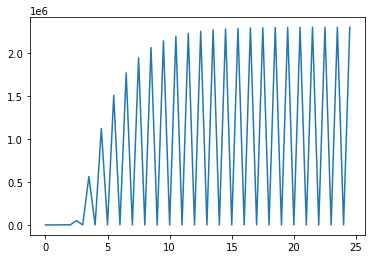

In [91]:
import matplotlib.pyplot as plt 

plt.plot(time,pltPop)

In [35]:
ImmSeed

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])